# Hydrangea Image Classification

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, foldernames, filenames in os.walk('/kaggle/input'): #path to input data
    for foldername in foldernames:
        print(os.path.join(dirname, foldername))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hydrangea-experiment
/kaggle/input/hydrangea-dataset-1
/kaggle/input/hydrangea-dataset-1/hydrangea macrophylla
/kaggle/input/hydrangea-dataset-1/hydrangea serrata
/kaggle/input/hydrangea-dataset-1/hydrangea quercifolia
/kaggle/input/hydrangea-dataset-1/climbing hydrangea
/kaggle/input/hydrangea-dataset-1/hydrangea konpeito


In [2]:
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [4]:
!pip show keras

Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: keras-tuner, tensorflow


## 1. Data Preparation

In [5]:
import tensorflow
import keras
import numpy as np
from matplotlib import pyplot as plt

### 1-1 Load Data

In [6]:
data_dir = '/kaggle/input/hydrangea-dataset-1'
data = keras.utils.image_dataset_from_directory(data_dir, label_mode="categorical")
class_names = data.class_names

Found 814 files belonging to 5 classes.


In [7]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [8]:
print(len(batch) ) #returns 2: image and labels
print(batch[0].shape) #Images represented as numbpy arrays

2
(32, 256, 256, 3)


In [9]:
batch[0].min()

0.0

In [10]:
batch[0].max()

255.0

### 1-2 Scale Data

In [11]:
data = data.map(lambda x, y: (x/255, y))
scale_iterator = data.as_numpy_iterator().next()

In [12]:
scale_iterator[0].min()

0.0

In [13]:
scale_iterator[0].max()

1.0

### 1-3 Split Data

In [14]:
len(data)

26

In [15]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size+val_size+test_size 
# make sure this matches the "len(data)" to make full use of your data

26

In [17]:
train_data = data.take(train_size)
validation_data = data.skip(train_size).take(val_size) #skip already used data
test_data = data.skip(train_size+val_size).take(test_size) #skip already used data

## 2. Model Building

### 2-1. Convolutional Neural Network

Having learned about CNN on [Computer Vision](https://www.kaggle.com/learn/computer-vision), I first tried to apply CNN on my own. The following is the entire code.

In [18]:
from keras import layers
model=keras.Sequential([
    # Base
    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same',
                 activation='relu', input_shape=[256,256,3]),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same',
                 activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same',
                 activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same',
                 activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(5, activation='softmax')

])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

## This is the interim model version used during the development process.
'''
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

print("Minimum validation loss: {}".format(history_frame['val_loss'].min()))
print("Maximum accuracy: {}".format(history_frame['val_accuracy'].max()))
'''

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        98,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,601 (1.57 MB)

 Trainable params: 410,601 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

'\nhistory = model.fit(\n    train_data,\n    validation_data=validation_data,\n    epochs=30,\n)\n\n# Plot learning curves\nimport pandas as pd\nhistory_frame = pd.DataFrame(history.history)\nhistory_frame.loc[:, [\'loss\', \'val_loss\']].plot()\nhistory_frame.loc[:, [\'accuracy\', \'val_accuracy\']].plot();\n\nprint("Minimum validation loss: {}".format(history_frame[\'val_loss\'].min()))\nprint("Maximum accuracy: {}".format(history_frame[\'val_accuracy\'].max()))\n'

While I increased the number of layers to make a complex model, it didn't perform well. Thinking this was due to the small size of the dataset, I decided to try different methods.

### 2-2. Transfer Learning 

Realizing that my dataset was too small to train a model from scratch, I decided to use a pretrained model (VGG16) and implement data augmentation.

#### 2-2-1 Initial Model

In [19]:
from keras.applications import VGG16


pretrained_base = VGG16(
    include_top=False,
    input_shape=(256, 256, 3),
    weights='imagenet',
    pooling='max',
    classifier_activation='softmax',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    layers.RandomFlip('horizontal'), # flip left-to-right
    layers.RandomRotation(factor=0.20),
    
    # Base
    pretrained_base,
    
    # Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Increased size
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.Dense(5, activation='softmax')  # Output layer for 5 classes
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
# This is the interim model version used during the development process.
'''
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping],
)
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

print("Minimum validation loss: {}".format(history_frame['val_loss'].min()))
print("Maximum accuracy: {}".format(history_frame['val_accuracy'].max()))

'''

'\nhistory = model.fit(\n    train_data,\n    validation_data=validation_data,\n    epochs=50,\n    callbacks=[early_stopping],\n)\n# Plot learning curves\nimport pandas as pd\nhistory_frame = pd.DataFrame(history.history)\nhistory_frame.loc[:, [\'loss\', \'val_loss\']].plot()\nhistory_frame.loc[:, [\'accuracy\', \'val_accuracy\']].plot();\n\nprint("Minimum validation loss: {}".format(history_frame[\'val_loss\'].min()))\nprint("Maximum accuracy: {}".format(history_frame[\'val_accuracy\'].max()))\n\n'

While training reached around 85% of validation accuracy with these methods, it was still volatile. To stabilize the training and aim for higher accuracy, I did the following:

1. Tried different learning rates:

* With a too small learning rate, the training started too slowly.
* With a too large learning rate, the training became too volatile towards the end.
* To address this, I introduced a learning rate schedule.

2. Tried different batch sizes:

* With a too small batch size, the training became too volatile.
* With a too large batch size, overfitting occurred.

3. Tried different numbers of epochs.

* Added data augmentation layers.

Along the way, both overfitting and underfitting occurred, so I added dropout layers but eventually commented them out. If the validation accuracy is consistently higher than the training accuracy, it indicates underfitting. Since this was the case, I removed the dropout layers.

#### 2-2-2 Final Model

In [22]:
pretrained_base = VGG16(
    include_top=False,
    input_shape=(256, 256, 3),
    weights='imagenet',
    pooling='max',
    classifier_activation='softmax',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    layers.RandomFlip('horizontal'), # flip left-to-right
    layers.RandomRotation(factor=0.20),
    layers.RandomZoom(0.20),
    
    # Base
    pretrained_base,
    
    # Head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Add batch normalization
    #layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),  # Increased size
    layers.BatchNormalization(),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.BatchNormalization(),
    #layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Output layer for 5 classes
])

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.3842 - loss: 1.5976 - val_accuracy: 0.1500 - val_loss: 15.6448 - learning_rate: 0.0100
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.6196 - loss: 1.0297 - val_accuracy: 0.2125 - val_loss: 17.4934 - learning_rate: 0.0100
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.6849 - loss: 0.8199 - val_accuracy: 0.3313 - val_loss: 9.0897 - learning_rate: 0.0100
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.7359 - loss: 0.6829 - val_accuracy: 0.3625 - val_loss: 5.2401 - learning_rate: 0.0100
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.7409 - loss: 0.6707 - val_accuracy: 0.3000 - val_loss: 6.7694 - learning_rate: 0.0100
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.7646 - loss: 0.6515 - val_accuracy: 0.1750 - val_loss: 8.4888 - learning_rate: 0.0100
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.7804 - loss:

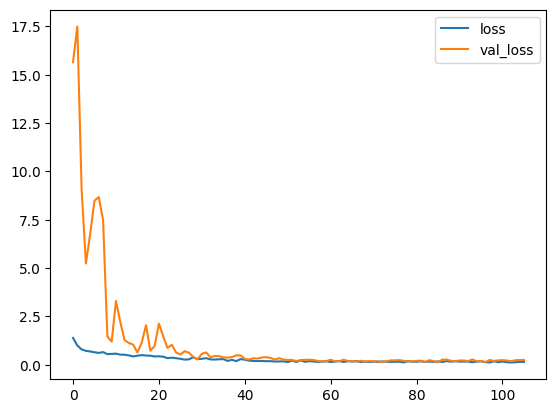

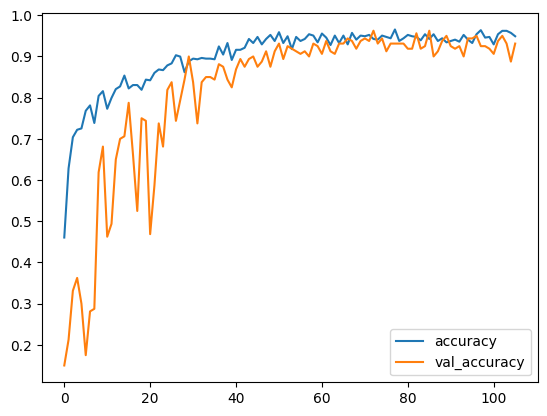

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)


history = model.fit(
    train_data,
    validation_data=validation_data,
    batch_size=128,
    epochs=200,
    callbacks=[early_stopping, reduce_lr],
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [25]:
print("Minimum validation loss: {}".format(history_frame['val_loss'].min()))
print("Maximum accuracy: {}".format(history_frame['val_accuracy'].max()))

Minimum validation loss: 0.12676259875297546
Maximum accuracy: 0.9624999761581421


## 3. Evaluation

In [26]:
from keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [27]:
for batch in test_data.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision0.9767441749572754, Recall:0.9130434989929199, Accuracy:0.97826087474823


### *Experiment with Images

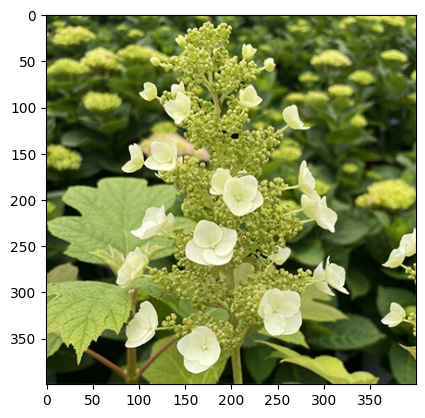

In [28]:
import cv2
img = cv2.imread('/kaggle/input/hydrangea-experiment/12780.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

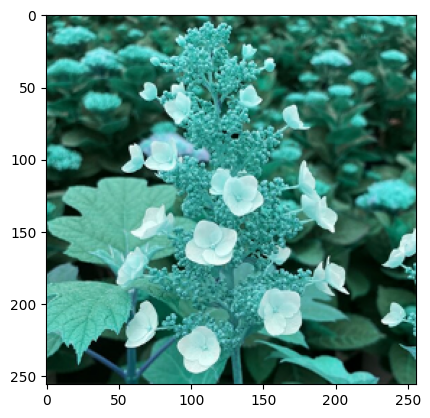

In [29]:
resize = tensorflow.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [30]:
np.expand_dims(resize,0)
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


In [31]:
# Convert probabilities to class name
predicted_class_index = np.argmax(yhat)  # Get the index of the class with the highest probability
predicted_class_name = class_names[predicted_class_index]  # Map index to class name

print(f"Predicted class: {predicted_class_name}")
print(f"Probabilities: {yhat}")

Predicted class: hydrangea quercifolia
Probabilities: [[0.00622179 0.02341131 0.01834417 0.93229014 0.01973258]]


## 4. Save the Model

In [32]:
model.save('hydrangea_model.keras')

In [33]:
loaded_model = keras.saving.load_model('/kaggle/working/hydrangea_model.keras')

In [34]:
for batch in test_data.as_numpy_iterator():
    X,y = batch
    yhat = loaded_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Precision0.9438202381134033, Recall:0.9130434989929199, Accuracy:0.9717390537261963
